In [ ]:
# 
# Build pCVR using GAP bigquery and Tensorflow DNN library 
# Used calibration period for training & holdout period for validation
# Script can be run on Compute Engine of GCP
# The query to extract GA360 features referred to an Auto case by Yiling Liu(yilliu@) 
# 
# By JeeWook Kim
#

<h1> Install libraries

In [1]:
%%bash
pip install --upgrade pip
pip install --upgrade google-api-python-client
pip install --upgrade gcloud
pip install tensorflow
pip install --ignore-installed --upgrade tensorflow==1.10.0

Requirement already up-to-date: pip in /usr/local/lib/python2.7/dist-packages (18.0)
Requirement already up-to-date: google-api-python-client in /usr/local/lib/python2.7/dist-packages (1.7.4)
Requirement already up-to-date: gcloud in /usr/local/lib/python2.7/dist-packages (0.18.3)
  Using cached https://files.pythonhosted.org/packages/40/73/010fe27e6544515909e959a54e49f4d2d34d829291a3b64ba2525d00db1f/tensorflow-1.10.0-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/6a/a9/c01a2d5f7b045f508c8cefef3b079fe8c413d05498ca0ae877cffa230564/numpy-1.14.5-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/b5/84/c0d0a0355f2e3ea1e49fd81aa123e0bf42bfaa58be56583cc3b9baaf2837/grpcio-1.14.1-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/b8/c2/b7f587c0aaf8bf2201405e8162323037fe8d17aa21d3c7dda811b8d01469/protobuf-3.6.1-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pytho

google-cloud 0.27.0 has requirement google-cloud-core<0.27dev,>=0.26.0, but you'll have google-cloud-core 0.27.1 which is incompatible.
google-cloud 0.27.0 has requirement google-cloud-storage<1.4dev,>=1.3.0, but you'll have google-cloud-storage 1.4.0 which is incompatible.
google-cloud-vision 0.26.0 has requirement google-cloud-core<0.27dev,>=0.26.0, but you'll have google-cloud-core 0.27.1 which is incompatible.
google-cloud-vision 0.26.0 has requirement google-gax<0.16dev,>=0.15.13, but you'll have google-gax 0.12.5 which is incompatible.
google-cloud-logging 1.2.0 has requirement google-cloud-core<0.27dev,>=0.26.0, but you'll have google-cloud-core 0.27.1 which is incompatible.
google-cloud-speech 0.28.0 has requirement google-cloud-core<0.27dev,>=0.26.0, but you'll have google-cloud-core 0.27.1 which is incompatible.
google-cloud-speech 0.28.0 has requirement google-gax<0.16dev,>=0.15.13, but you'll have google-gax 0.12.5 which is incompatible.
google-cloud-videointelligence 0.25.

<h1> Import libraries

In [58]:
import tensorflow as tf
print(tf.__version__)
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import urllib
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import google.datalab.bigquery as bq
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(precision=4, suppress=True)
from sklearn import metrics
import matplotlib.pyplot as plt


1.10.0


<h1> Prepare dataset using GA360

In [3]:
today = datetime.date.today().strftime("%Y%m%d")
begin_date = '20160801'
end_date = '20170630'
holdout_percent = '25'
holdout_bucket = '3'
predict_begin = '20170701'
predict_end = '20170801'
calibration_end_date = '20170201'
# Googel Store demo table
gap_table = 'bigquery-public-data.google_analytics_sample.ga_sessions_*'

print('# today: {}'.format(today))
print('# begin_date: {}'.format(begin_date))
print('# end_date: {}'.format(end_date))
print('# calibration_end_date: {}'.format(calibration_end_date))
# query to retrieve GAP exported BigQuery 
sql_train = """ 
          WITH ga_raw AS ( -- hit level data
          SELECT
            date,
            fullVisitorId,
            channelGrouping,
            socialEngagementType,
            visitId,
            visitNumber,
            trafficSource.source,
            trafficSource.medium,
            device.deviceCategory,
            device.browser,
            hits.hitNumber,
            hits.page.pagePath as pagePath,
            hits.type as type,
            hits.eventInfo.eventCategory as eventCategory,
            hits.eventInfo.eventAction as eventAction,
            hits.eventInfo.eventLabel as eventLabel,
            TIMESTAMP_SECONDS(visitStartTime) AS sessionStartTtime, 
            TIMESTAMP_ADD(TIMESTAMP_SECONDS(visitStartTime), INTERVAL hits.time MILLISECOND) AS hitTime,
            CASE WHEN hits.hour IN (5,6,7,8,9,10) THEN 1 ELSE 0 END AS morningVisit,
            CASE WHEN hits.hour IN (11,12,13,14,15,16) THEN 1 ELSE 0 END AS dayVisit,
            CASE WHEN hits.hour IN (17,18,19,20,21,22) THEN 1 ELSE 0 END AS eveningVisit,
            totals.timeOnSite AS timeOnSite,
            totals.bounces AS bounceNumber,
            totals.timeOnScreen	AS timeOnScreen,
            totals.transactions AS transactions,
            IF(REGEXP_CONTAINS(trafficSource.source , 'google') AND REGEXP_CONTAINS(trafficSource.medium , 'cpc'), 1, 0) AS fromPaidSearch,
            IF(REGEXP_CONTAINS(trafficSource.source , 'google') AND REGEXP_CONTAINS(trafficSource.medium , 'organic'), 1, 0) AS fromOrganicSearch
          FROM `"""+gap_table+"""`, unnest(hits) as hits
          WHERE
           (_TABLE_SUFFIX >= '"""+begin_date+"""' AND _TABLE_SUFFIX <= '"""+end_date+"""') 
           AND TRUNC(MOD(FARM_FINGERPRINT(fullVisitorId), 100) / """+holdout_percent+""") != """+holdout_bucket+""" )
           ,
       
        session AS ( -- aggregate hit level to session level
          SELECT fullVisitorId, visitId,
            SUM(if (timeOnSite is null, 0, timeOnSite)) AS timeOnSite,
            SUM(if (bounceNumber is null, 0, bounceNumber)) AS bounceNumber,
            SUM( dayVisit ) AS dayVisit,
            SUM( eveningVisit ) AS eveningVisit ,
            SUM( morningVisit ) AS morningVisit ,
            ANY_VALUE(visitNumber) as visitNumber,

            SUM(if( type = 'PAGE', 1, 0)) as totalPageViews, 
            SUM(if( type = 'EVENT', 1, 0)) as totalEvents, 

            SUM(if(pagePath LIKE '%/apparel%', 1, 0)) as apparelViews,
            SUM(if(pagePath LIKE '%/bags%', 1, 0)) as bagsViews,
            SUM(if(pagePath LIKE '%/drinkware%', 1, 0)) as drinkwareViews,
            SUM(if(pagePath LIKE '%/accessories%', 1, 0)) as accessoriesViews,
            SUM(if(pagePath LIKE '%/office%', 1, 0)) as officeViews,

            IF(SUM(fromPaidSearch) != 0, 1, 0) AS  fromPaidSearch,
            IF(SUM(fromOrganicSearch) != 0, 1, 0) AS  fromOrganicSearch,

            IF(SUM(transactions) is null, False, True) AS hasConverted,

            COUNT(*) as totalInteractions    
          FROM ga_raw
          GROUP BY fullVisitorId , visitId ),
  
       ml_dataset AS ( -- aggregate seesion level data to user level

          SELECT 
            fullVisitorId, 
            MAX(visitNumber) as totalSessions,
            SUM(totalPageViews) as totalPageViews, 
            SUM(totalInteractions) as totalInteractions, 

            SUM(timeOnSite) AS timeOnSite,
            SUM(bounceNumber) AS bounceNumber,
            SUM( dayVisit ) AS dayVisit,
            SUM( eveningVisit ) AS eveningVisit ,
            SUM( morningVisit ) AS morningVisit ,

            SUM(totalEvents) as totalEvents, 

            SUM(apparelViews) as apparelViews,
            SUM(bagsViews) as bagsViews,
            SUM(drinkwareViews)  as drinkwareViews,
            SUM(accessoriesViews) as accessoriesViews,
            SUM(officeViews) as officeViews,

            SUM(fromPaidSearch) AS fromPaidSearch,
            SUM(fromOrganicSearch) AS fromOrganicSearch,
            ANY_VALUE(hasConverted) AS hasConverted

          FROM session
          GROUP BY fullVisitorId)

        select * from ml_dataset; 
"""

print ('# BigQuery SQL - train data')  
print (sql_train)
    
sql_test = """ 
         WITH ga_raw AS (
          SELECT
            date,
            fullVisitorId,
            channelGrouping,
            socialEngagementType,
            visitId,
            visitNumber,
            trafficSource.source,
            trafficSource.medium,
            device.deviceCategory,
            device.browser,
            hits.hitNumber,
            hits.page.pagePath as pagePath,
            hits.type as type,
            hits.eventInfo.eventCategory as eventCategory,
            hits.eventInfo.eventAction as eventAction,
            hits.eventInfo.eventLabel as eventLabel,
            TIMESTAMP_SECONDS(visitStartTime) AS sessionStartTtime, 
            TIMESTAMP_ADD(TIMESTAMP_SECONDS(visitStartTime), INTERVAL hits.time MILLISECOND) AS hitTime,
            CASE WHEN hits.hour IN (5,6,7,8,9,10) THEN 1 ELSE 0 END AS morningVisit,
            CASE WHEN hits.hour IN (11,12,13,14,15,16) THEN 1 ELSE 0 END AS dayVisit,
            CASE WHEN hits.hour IN (17,18,19,20,21,22) THEN 1 ELSE 0 END AS eveningVisit,
            totals.timeOnSite AS timeOnSite,
            totals.bounces AS bounceNumber,
            totals.timeOnScreen	AS timeOnScreen,
            totals.transactions AS transactions,
            IF(REGEXP_CONTAINS(trafficSource.source , 'google') AND REGEXP_CONTAINS(trafficSource.medium , 'cpc'), 1, 0) AS fromPaidSearch,
            IF(REGEXP_CONTAINS(trafficSource.source , 'google') AND REGEXP_CONTAINS(trafficSource.medium , 'organic'), 1, 0) AS fromOrganicSearch
          FROM `"""+gap_table+"""`, unnest(hits) as hits
          WHERE
           (_TABLE_SUFFIX > '"""+begin_date+"""' AND _TABLE_SUFFIX <= '"""+end_date+"""') 
           AND TRUNC(MOD(FARM_FINGERPRINT(fullVisitorId), 100) / """+holdout_percent+""") = """+holdout_bucket+""" )
          ,
       
        session AS ( -- aggregate hit level to session level
          SELECT fullVisitorId, visitId,
            SUM(if (timeOnSite is null, 0, timeOnSite)) AS timeOnSite,
            SUM(if (bounceNumber is null, 0, bounceNumber)) AS bounceNumber,
            SUM( dayVisit ) AS dayVisit,
            SUM( eveningVisit ) AS eveningVisit ,
            SUM( morningVisit ) AS morningVisit ,
            ANY_VALUE(visitNumber) as visitNumber,

            SUM(if( type = 'PAGE', 1, 0)) as totalPageViews, 
            SUM(if( type = 'EVENT', 1, 0)) as totalEvents, 

            SUM(if(pagePath LIKE '%/apparel%', 1, 0)) as apparelViews,
            SUM(if(pagePath LIKE '%/bags%', 1, 0)) as bagsViews,
            SUM(if(pagePath LIKE '%/drinkware%', 1, 0)) as drinkwareViews,
            SUM(if(pagePath LIKE '%/accessories%', 1, 0)) as accessoriesViews,
            SUM(if(pagePath LIKE '%/office%', 1, 0)) as officeViews,

            IF(SUM(fromPaidSearch) != 0, 1, 0) AS  fromPaidSearch,
            IF(SUM(fromOrganicSearch) != 0, 1, 0) AS  fromOrganicSearch,

            IF(SUM(transactions) is null, False, True) AS hasConverted,

            COUNT(*) as totalInteractions    
          FROM ga_raw
          GROUP BY fullVisitorId , visitId ),
  
       ml_dataset AS ( -- aggregate seesion level data to user level

          SELECT 
            fullVisitorId, 
            MAX(visitNumber) as totalSessions,
            SUM(totalPageViews) as totalPageViews, 
            SUM(totalInteractions) as totalInteractions, 

            SUM(timeOnSite) AS timeOnSite,
            SUM(bounceNumber) AS bounceNumber,
            SUM( dayVisit ) AS dayVisit,
            SUM( eveningVisit ) AS eveningVisit ,
            SUM( morningVisit ) AS morningVisit ,

            SUM(totalEvents) as totalEvents, 

            SUM(apparelViews) as apparelViews,
            SUM(bagsViews) as bagsViews,
            SUM(drinkwareViews)  as drinkwareViews,
            SUM(accessoriesViews) as accessoriesViews,
            SUM(officeViews) as officeViews,

            SUM(fromPaidSearch) AS fromPaidSearch,
            SUM(fromOrganicSearch) AS fromOrganicSearch,
            ANY_VALUE(hasConverted) AS hasConverted

          FROM session
          GROUP BY fullVisitorId)

        select * from ml_dataset; 
"""

print ('# BigQuery SQL - test data')  
print (sql_test)

sql_predict = """ 
         WITH ga_raw AS (
          SELECT
            date,
            fullVisitorId,
            channelGrouping,
            socialEngagementType,
            visitId,
            visitNumber,
            trafficSource.source,
            trafficSource.medium,
            device.deviceCategory,
            device.browser,
            hits.hitNumber,
            hits.page.pagePath as pagePath,
            hits.type as type,
            hits.eventInfo.eventCategory as eventCategory,
            hits.eventInfo.eventAction as eventAction,
            hits.eventInfo.eventLabel as eventLabel,
            TIMESTAMP_SECONDS(visitStartTime) AS sessionStartTtime, 
            TIMESTAMP_ADD(TIMESTAMP_SECONDS(visitStartTime), INTERVAL hits.time MILLISECOND) AS hitTime,
            CASE WHEN hits.hour IN (5,6,7,8,9,10) THEN 1 ELSE 0 END AS morningVisit,
            CASE WHEN hits.hour IN (11,12,13,14,15,16) THEN 1 ELSE 0 END AS dayVisit,
            CASE WHEN hits.hour IN (17,18,19,20,21,22) THEN 1 ELSE 0 END AS eveningVisit,
            totals.timeOnSite AS timeOnSite,
            totals.bounces AS bounceNumber,
            totals.timeOnScreen	AS timeOnScreen,
            totals.transactions AS transactions,
            IF(REGEXP_CONTAINS(trafficSource.source , 'google') AND REGEXP_CONTAINS(trafficSource.medium , 'cpc'), 1, 0) AS fromPaidSearch,
            IF(REGEXP_CONTAINS(trafficSource.source , 'google') AND REGEXP_CONTAINS(trafficSource.medium , 'organic'), 1, 0) AS fromOrganicSearch
          FROM `"""+gap_table+"""`, unnest(hits) as hits
          WHERE
           (_TABLE_SUFFIX > '"""+predict_begin+"""' AND _TABLE_SUFFIX <= '"""+predict_end+"""') )
          ,
       
        session AS ( -- aggregate hit level to session level
          SELECT fullVisitorId, visitId,
            SUM(if (timeOnSite is null, 0, timeOnSite)) AS timeOnSite,
            SUM(if (bounceNumber is null, 0, bounceNumber)) AS bounceNumber,
            SUM( dayVisit ) AS dayVisit,
            SUM( eveningVisit ) AS eveningVisit ,
            SUM( morningVisit ) AS morningVisit ,
            ANY_VALUE(visitNumber) as visitNumber,

            SUM(if( type = 'PAGE', 1, 0)) as totalPageViews, 
            SUM(if( type = 'EVENT', 1, 0)) as totalEvents, 

            SUM(if(pagePath LIKE '%/apparel%', 1, 0)) as apparelViews,
            SUM(if(pagePath LIKE '%/bags%', 1, 0)) as bagsViews,
            SUM(if(pagePath LIKE '%/drinkware%', 1, 0)) as drinkwareViews,
            SUM(if(pagePath LIKE '%/accessories%', 1, 0)) as accessoriesViews,
            SUM(if(pagePath LIKE '%/office%', 1, 0)) as officeViews,

            IF(SUM(fromPaidSearch) != 0, 1, 0) AS  fromPaidSearch,
            IF(SUM(fromOrganicSearch) != 0, 1, 0) AS  fromOrganicSearch,

            IF(SUM(transactions) is null, False, True) AS hasConverted,

            COUNT(*) as totalInteractions    
          FROM ga_raw
          GROUP BY fullVisitorId , visitId ),
  
       ml_dataset AS ( -- aggregate seesion level data to user level

          SELECT 
            fullVisitorId, 
            MAX(visitNumber) as totalSessions,
            SUM(totalPageViews) as totalPageViews, 
            SUM(totalInteractions) as totalInteractions, 

            SUM(timeOnSite) AS timeOnSite,
            SUM(bounceNumber) AS bounceNumber,
            SUM( dayVisit ) AS dayVisit,
            SUM( eveningVisit ) AS eveningVisit ,
            SUM( morningVisit ) AS morningVisit ,

            SUM(totalEvents) as totalEvents, 

            SUM(apparelViews) as apparelViews,
            SUM(bagsViews) as bagsViews,
            SUM(drinkwareViews)  as drinkwareViews,
            SUM(accessoriesViews) as accessoriesViews,
            SUM(officeViews) as officeViews,

            SUM(fromPaidSearch) AS fromPaidSearch,
            SUM(fromOrganicSearch) AS fromOrganicSearch,
            ANY_VALUE(hasConverted) AS hasConverted

          FROM session
          GROUP BY fullVisitorId)

        select * from ml_dataset; 
"""

print ('# BigQuery SQL - predict data')  
print (sql_predict)


# execute the query using datalab lib

transaction_query = bq.Query(sql_train)
query_result = transaction_query.execute()
query_data = query_result.result().to_dataframe()
        
test_transaction_query = bq.Query(sql_test)
test_query_result = test_transaction_query.execute()
test_query_data = test_query_result.result().to_dataframe()

predict_transaction_query = bq.Query(sql_predict)
predict_query_result = predict_transaction_query.execute()
predict_query_data = predict_query_result.result().to_dataframe()


# today: 20180819
# begin_date: 20160801
# end_date: 20170630
# calibration_end_date: 20170201
# BigQuery SQL - train data
 
          WITH ga_raw AS ( -- hit level data
          SELECT
            date,
            fullVisitorId,
            channelGrouping,
            socialEngagementType,
            visitId,
            visitNumber,
            trafficSource.source,
            trafficSource.medium,
            device.deviceCategory,
            device.browser,
            hits.hitNumber,
            hits.page.pagePath as pagePath,
            hits.type as type,
            hits.eventInfo.eventCategory as eventCategory,
            hits.eventInfo.eventAction as eventAction,
            hits.eventInfo.eventLabel as eventLabel,
            TIMESTAMP_SECONDS(visitStartTime) AS sessionStartTtime, 
            TIMESTAMP_ADD(TIMESTAMP_SECONDS(visitStartTime), INTERVAL hits.time MILLISECOND) AS hitTime,
            CASE WHEN hits.hour IN (5,6,7,8,9,10) THEN 1 ELSE 0 END AS morningVisit,

<h1>Examin the dataset

In [4]:
print("# Training dataset")
query_data.describe()

# Training dataset


,totalSessions,totalPageViews,totalInteractions,timeOnSite,bounceNumber,dayVisit,eveningVisit,morningVisit,totalEvents,apparelViews,bagsViews,drinkwareViews,accessoriesViews,officeViews,fromPaidSearch,fromOrganicSearch
count,574628.00,574628.00,574628.00,574628.00,574628.00,574628.00,574628.00,574628.00,574628.00,574628.00,574628.00,574628.00,574628.00,574628.00,574628.00,574628.00
mean,1.32,4.87,5.81,3720.19,0.63,1.93,1.35,1.66,0.94,1.09,0.44,0.21,0.31,0.30,0.04,0.51
std,2.02,14.44,18.79,48539.95,0.95,9.21,7.13,9.29,4.86,5.82,2.67,1.55,1.93,2.18,0.34,1.03
min,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,2.00,2.00,8.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,4.00,4.00,360.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
max,389.00,4107.00,4942.00,16683459.00,186.00,1634.00,632.00,3212.00,835.00,1673.00,311.00,318.00,315.00,268.00,128.00,248.00


In [5]:
print("# Test dataset")
test_query_data.describe()   

# Test dataset


,totalSessions,totalPageViews,totalInteractions,timeOnSite,bounceNumber,dayVisit,eveningVisit,morningVisit,totalEvents,apparelViews,bagsViews,drinkwareViews,accessoriesViews,officeViews,fromPaidSearch,fromOrganicSearch
count,82365.00,82365.00,82365.00,82365.00,82365.00,82365.00,82365.00,82365.00,82365.00,82365.00,82365.00,82365.00,82365.00,82365.00,82365.00,82365.00
mean,1.31,4.86,5.79,3674.18,0.63,1.92,1.30,1.70,0.93,1.06,0.45,0.22,0.32,0.29,0.03,0.51
std,1.72,12.75,16.69,41180.64,0.81,8.91,6.27,7.91,4.43,4.76,2.55,1.45,1.89,2.16,0.28,0.93
min,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,2.00,2.00,6.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,4.00,4.00,360.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
max,192.00,858.00,1047.00,5818319.00,40.00,574.00,284.00,469.00,299.00,398.00,107.00,90.00,87.00,191.00,24.00,66.00


In [6]:
print("# Predict dataset")
predict_query_data.describe()   

# Predict dataset


,totalSessions,totalPageViews,totalInteractions,timeOnSite,bounceNumber,dayVisit,eveningVisit,morningVisit,totalEvents,apparelViews,bagsViews,drinkwareViews,accessoriesViews,officeViews,fromPaidSearch,fromOrganicSearch
count,58729.00,58729.00,58729.00,58729.00,58729.00,58729.00,58729.00,58729.00,58729.00,58729.00,58729.00,58729.00,58729.00,58729.00,58729.00,58729.00
mean,1.49,4.68,5.61,3781.54,0.63,1.86,1.34,1.53,0.93,1.16,0.51,0.19,0.34,0.27,0.04,0.64
std,3.49,9.68,13.21,29857.79,0.77,7.43,5.83,6.31,4.01,4.77,2.67,1.15,1.72,1.88,0.27,0.82
min,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,2.00,2.00,8.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,1.00,4.00,5.00,472.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
max,395.00,466.00,696.00,2416859.00,35.00,302.00,203.00,429.00,230.00,276.00,145.00,64.00,95.00,99.00,24.00,47.00


In [7]:
print('# query_data # of converted users {}'.format(query_data[query_data['hasConverted']==True].shape[0]))
print(query_data[query_data['hasConverted']==True].head(20))
print('# query_data # of not converted users {}'.format(query_data[query_data['hasConverted']==False].shape[0]))
print(query_data[query_data['hasConverted']==False].head(20))
 

# query_data # of converted users 4437
              fullVisitorId  totalSessions  totalPageViews  totalInteractions  \
0       6453870986532490896              5             192                256   
304239  6599797229931004781              1               5                  5   
314520  0213071560453106423              1               6                  6   
323508  9840650149470197060              1               7                  7   
325215  8281062230897695095              1               7                  7   
326573  3852898494139903793              1               7                  7   
328048  8951208689934718226              1               8                  8   
328985  7651728310132014868              1               8                  8   
329517  5640250262390805538              1               8                  8   
331185  4272803504302903779              1               8                  8   
331418  2326342894526494508              1               8            

<h1> Break dataframe dataset into features and labels

In [70]:
training_set_data = query_data.drop('hasConverted', axis=1, inplace=False)
training_set_target = query_data["hasConverted"]
test_set_data = test_query_data.drop('hasConverted', axis=1, inplace=False)
test_set_target = test_query_data["hasConverted"]
test_set_target.describe()

count     82365
unique        2
top       False
freq      81730
Name: hasConverted, dtype: object

<h1> Select Model (Tensorflow DNN Classifier)

In [96]:
# Specify that all features have real-value data
FEATURES = ["totalSessions", "totalPageViews", "totalInteractions", "timeOnSite", "bounceNumber",
            "dayVisit", "eveningVisit", "morningVisit", "totalEvents","apparelViews",
            "bagsViews","drinkwareViews","accessoriesViews","officeViews","fromPaidSearch",
            "fromOrganicSearch"]
feature_columns = [tf.feature_column.numeric_column(x) for x in FEATURES] 

# Specify optimizer
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
# Configurations for an Estimator
rc = tf.estimator.RunConfig(save_checkpoints_steps = 1000, 
                            keep_checkpoint_max = 2)
# Build DNN
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                        hidden_units=[64,64,32,32,32,32,16,8],
                                        optimizer=my_optimizer,
                                        activation_fn=tf.nn.selu,
                                        config = rc,
                                        n_classes=2,
                                        model_dir="./models/pcvr_model_11")


INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 2, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1192119ed0>, '_evaluation_master': '', '_save_checkpoints_steps': 1000, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './models/pcvr_model_11', '_train_distribute': None, '_save_summary_steps': 100}


<h1> Train Model

In [97]:
# Define the training inputs
train_input_fn = tf.estimator.inputs.pandas_input_fn(
  x=training_set_data,
  y=pd.Series(data=training_set_target.values, dtype=np.bool),
  num_epochs=None,
  batch_size=512,
  shuffle=True) 
# Train model.
classifier.train(input_fn=train_input_fn, steps=3000)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./models/pcvr_model_11/model.ckpt.
INFO:tensorflow:loss = 599.65894, step = 1
INFO:tensorflow:global_step/sec: 63.9538
INFO:tensorflow:loss = 0.00021667349, step = 101 (1.566 sec)
INFO:tensorflow:global_step/sec: 68.6017
INFO:tensorflow:loss = 12929.815, step = 201 (1.457 sec)
INFO:tensorflow:global_step/sec: 68.6036
INFO:tensorflow:loss = 0.11507973, step = 301 (1.458 sec)
INFO:tensorflow:global_step/sec: 66.8582
INFO:tensorflow:loss = 0.0069542555, step = 401 (1.497 sec)
INFO:tensorflow:global_step/sec: 68.4351
INFO:tensorflow:loss = 0.036550894, step = 501 (1.462 sec)
INFO:tensorflow:global_step/sec: 69.3949
INFO:tensorflow:loss = 1486.9645, step = 601 (1.440 sec)
INFO:tensorflow:global_step/sec: 67.1754


<h1>Test and Evaluate Model

In [98]:
# Define the test inputs
test_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=test_set_data,
    y=pd.Series(data=test_set_target.values, dtype=np.bool),
    num_epochs=1,
    shuffle=False)
# Evaluate 
evaluation_metrics = classifier.evaluate(input_fn=test_input_fn)
print("# Test set metrics")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-19-09:10:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/pcvr_model_11/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-19-09:10:23
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.96008015, accuracy_baseline = 0.99229044, auc = 0.9201437, auc_precision_recall = 0.37723348, average_loss = 1.5738951, global_step = 3000, label/mean = 0.0077095856, loss = 201.29483, precision = 0.12791024, prediction/mean = 0.044604447, recall = 0.71811026
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: ./models/pcvr_model_11/model.ckpt-3000
# Test set metrics
loss 201.29483
accuracy_baseline 0.99229044
global_step 3000
recall 0.71811026
auc 0.9201437
prediction/mean 0.044604447
precision 0.12791024
label/mean 0.0

<h1> Evaluate model using sklearn.metrics

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/pcvr_model_11/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Average precision-recall score: 0.31


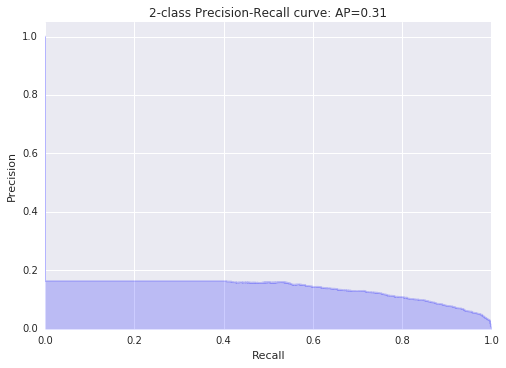

In [99]:
predictions = classifier.predict(input_fn=test_input_fn)
probabilities = np.array([item['probabilities'][1] for item in predictions])

average_precision = metrics.average_precision_score(pd.Series(data=test_set_target.values, dtype=np.bool), probabilities)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, _ = metrics.precision_recall_curve(pd.Series(data=test_set_target.values, dtype=np.bool), probabilities)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

<h1> Predict

In [100]:
new_input = predict_query_data.drop('hasConverted', axis=1, inplace=False)
new_input_key = predict_query_data.as_matrix(columns=["fullVisitorId"])
predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=new_input,
    num_epochs=1,
    shuffle=False)

predictions = classifier.predict(input_fn=predict_input_fn)

In [101]:
probabilities = np.array([item['probabilities'][1] for item in predictions])
# add additional dimension to merge with fullVisitorId np array
probabilities = probabilities[:,np.newaxis] 
score = pd.DataFrame(np.hstack((new_input_key, probabilities)), columns=['fullVisitorId','probability'])

score.describe()


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/pcvr_model_11/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


,fullVisitorId,probability
count,58729,58729.00
unique,58729,24053.00
top,7824468735492343020,0.00
freq,1,3621.00


In [102]:
score.sort_values('probability', ascending=False).head(50)


,fullVisitorId,probability
58728,0232377434237234751,1.00
25894,8624185886173345427,1.00
25895,0143782636543876435,1.00
26388,6726005262509028823,1.00
25896,1247282406356396417,1.00
57808,4250649142941130193,1.00
26205,4496929138237376433,1.00
57809,279752518121593865,1.00
57810,7896757585322523184,1.00
57811,764033642307406325,1.00
